# 05 - SONG LYRICS EDA

In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Load data

In [3]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

,rank,song,artist_base,artist_all,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,...,speechiness,tempo,time_signature,valence,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
5325,17,say something,a great big world,a great big world and christina aguilera,2014,NaN,say something,a great big world,say something im giving up on you ill be the ...,0.8570,...,0.0355,141.284,3.0,0.0765,3.823333,142.0,0.619006,52.0,2010,2.730769
2928,37,"don't worry, be happy",bobby mcferrin,bobby mcferrin,1988,NaN,dont worry be happy,bobby mcferrin,heres a little song i wrote you might want to ...,0.8810,...,0.1650,69.283,4.0,0.7710,4.873333,254.0,0.868673,89.0,1980,2.853933
3298,10,just another day,jon secada,jon secada,1992,NaN,just another day,jon secada,mornings alone when you come home i breathe a ...,0.0194,...,0.0287,105.894,4.0,0.7320,5.457117,258.0,0.787962,70.0,1990,3.685714


## Word2Vec 

In [4]:
# generate distributed representations of tokens that appear more than twice
min_count = 2
lyrics = df['lyrics'].dropna().values.tolist()
lyrics_tokenized = [lyric.split() for lyric in lyrics]
model = Word2Vec(lyrics_tokenized, size=50, min_count=min_count, window=5)

# create a list of tokens sorted by their frequency
count = CountVectorizer(stop_words='english')
count.fit(np.array(lyrics))
freqs = np.array(count.transform(np.array(lyrics)).todense()).sum(axis=0)
mask = freqs >= min_count
indices = np.argsort(-freqs).squeeze().tolist()
freqs_filtered = freqs[indices]
words_sorted = np.array(count.get_feature_names())[indices]

# project the word embeddings of top n_words_display words down to 2 dimensions
n_words_display = 200
X = model[words_sorted[:n_words_display]]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [5]:
# print most similar words to query_words
query_words = ['you', 'love', 'dance', 'oh', 'money']
similar_words = [[res[0] for res in model.wv.most_similar(qw)] \
                         for qw in query_words]
for word in query_words:
    print('|{:^15}|'.format(word), end='')
print()
print('=' * 85)
for i in range(10):
    for j in range(5):
        print('|{:^15}|'.format(similar_words[j][i]), end='')
    print()

|      you      ||     love      ||     dance     ||      oh       ||     money     |
|       i       ||     true      ||     move      ||     whoa      ||     shit      |
|      me       ||    believe    ||    boogie     ||     woah      ||     dough     |
|     baby      ||     baby      ||     floor     ||    darling    ||     price     |
|   anything    ||    loving     ||    dancing    ||      yes      ||     bank      |
|      if       ||     life      ||     roll      ||     baby      ||     bitch     |
|      it       ||      you      ||     rock      ||     yeah      ||     cash      |
|     love      ||      yes      ||  bourgeoisie  ||    darlin     ||     fuck      |
|     just      ||    because    ||    groove     ||     lord      ||    bitches    |
|      now      ||     that      ||      get      ||     oooh      ||      pay      |
|     girl      ||     lovin     ||     party     ||      ohh      ||      sex      |


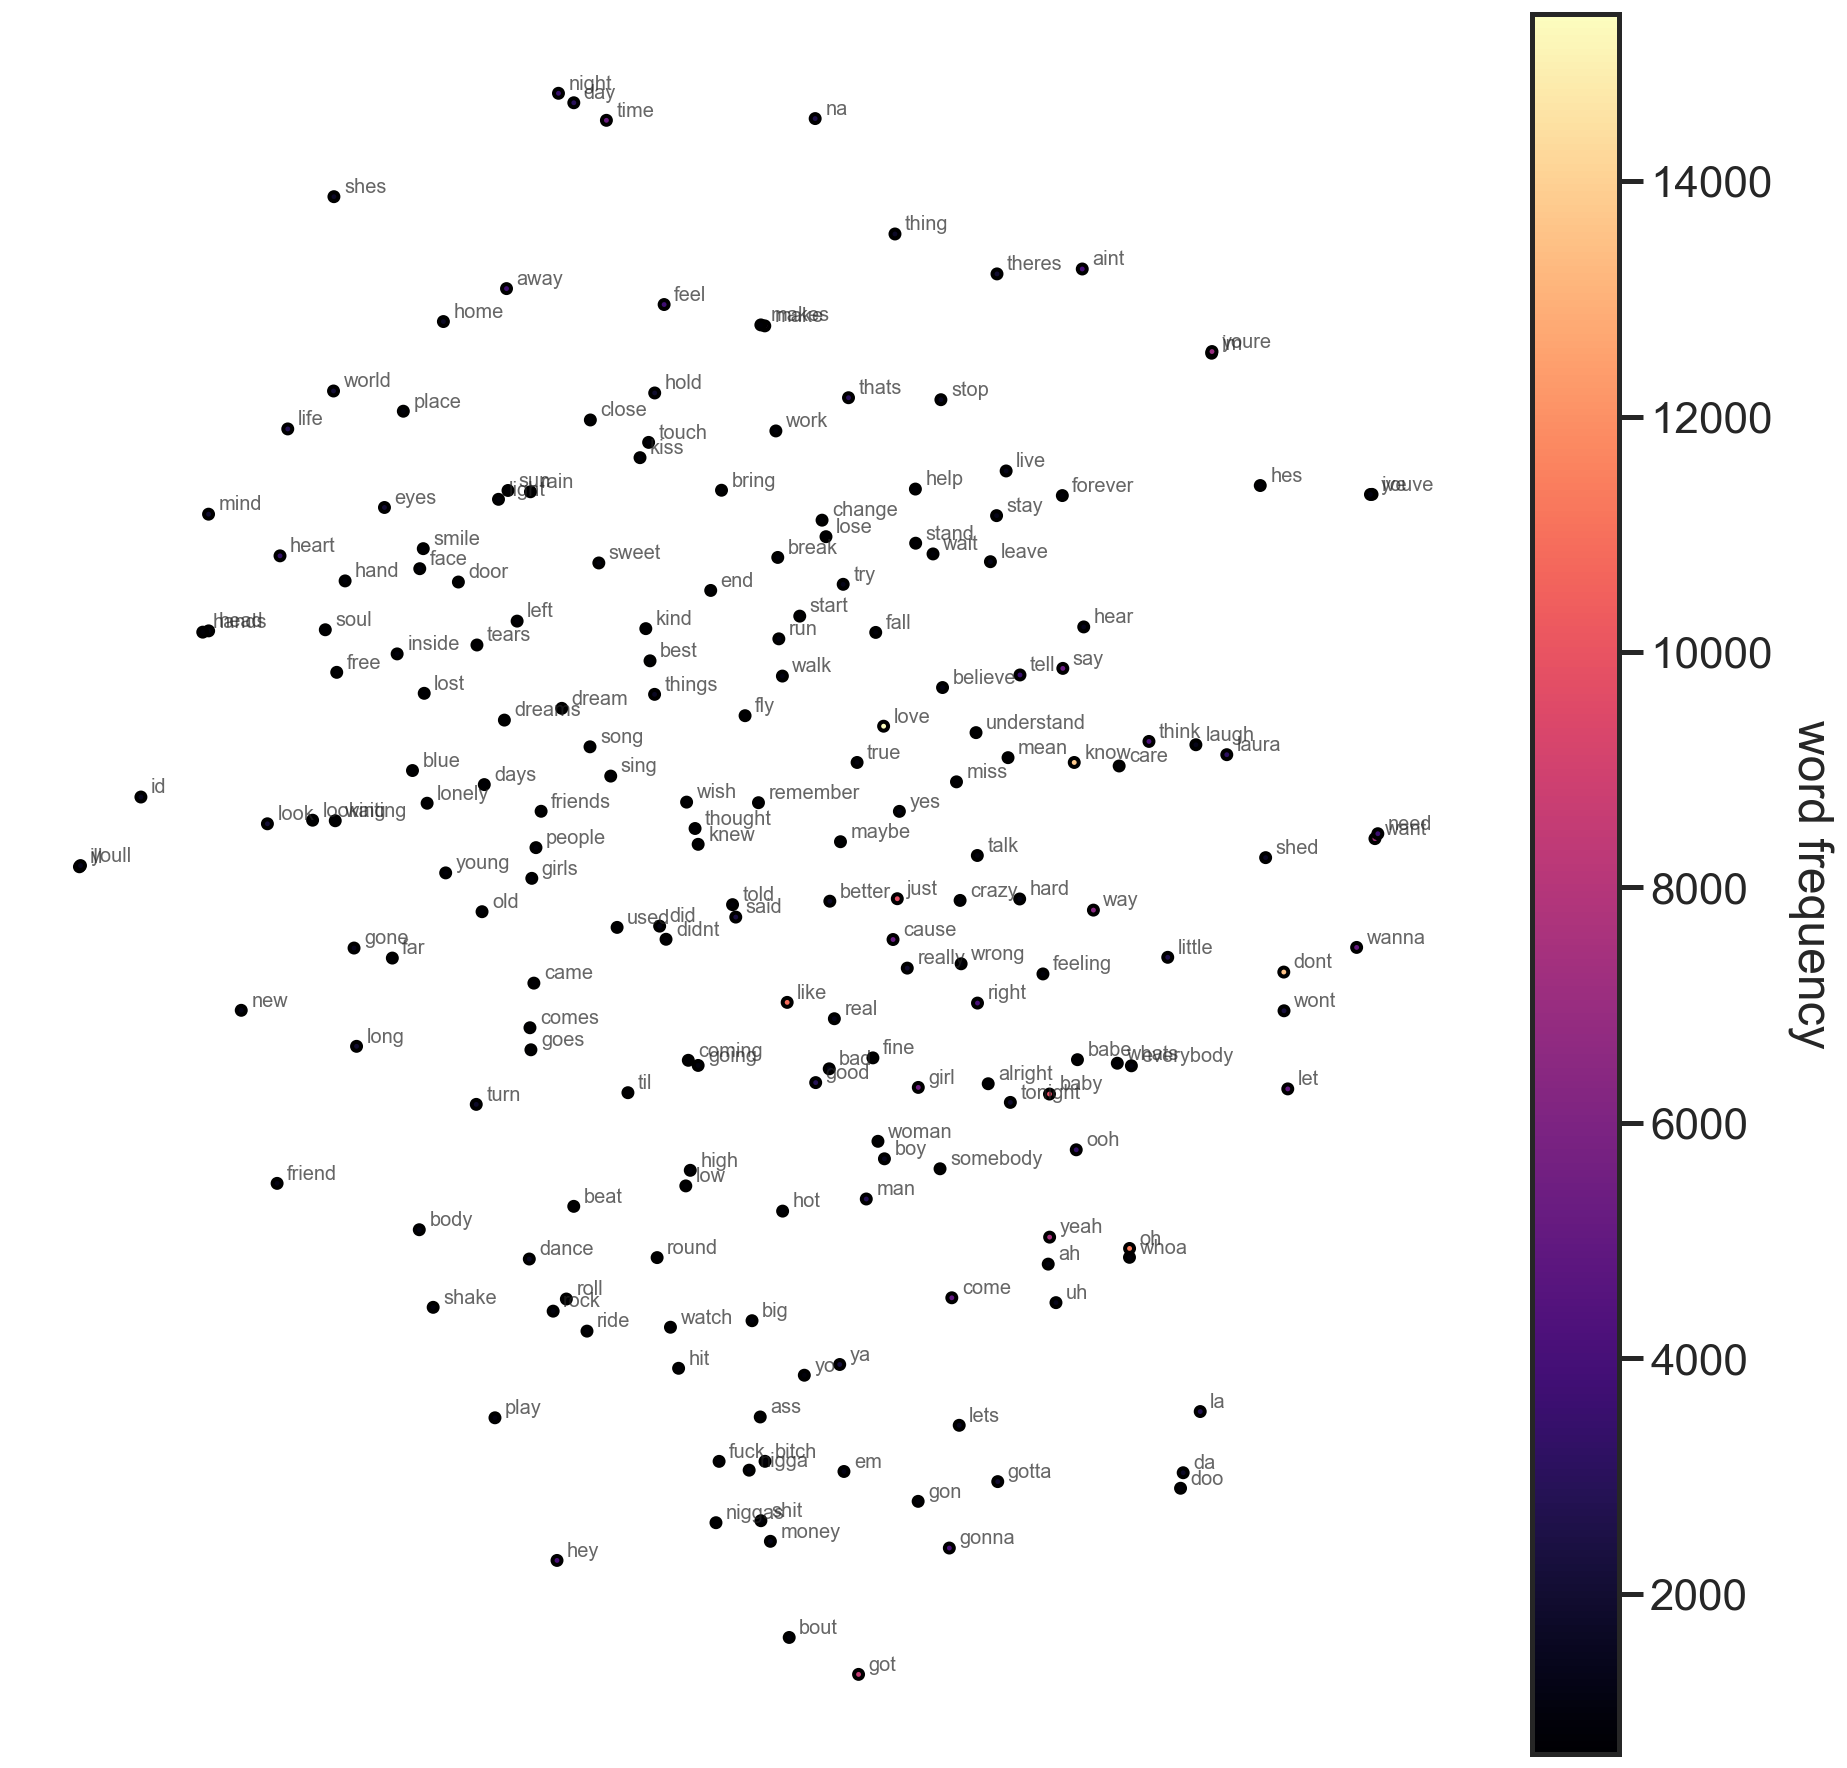

In [7]:
# plot 2D projections of top n_words_display words
plt.figure(figsize=(16,16))
ax = plt.gca()
cb = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=20, c=freqs_filtered[:n_words_display],
                cmap='magma', edgecolor='black')
cb = plt.colorbar(cb)
cb.set_label('word frequency', rotation=270, labelpad=30)
ax.axis('off')

# annotate each point
for index, word in enumerate(words_sorted[:n_words_display]):
    xy = X_tsne[index]
    ax.annotate(word, xy=xy, xytext=(5,2), textcoords='offset points',
                 alpha=0.7)
plt.savefig('word-embeddings.png')

## Most popular words 

In [9]:
# when creating word clouds, maps word fontsize to a color
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

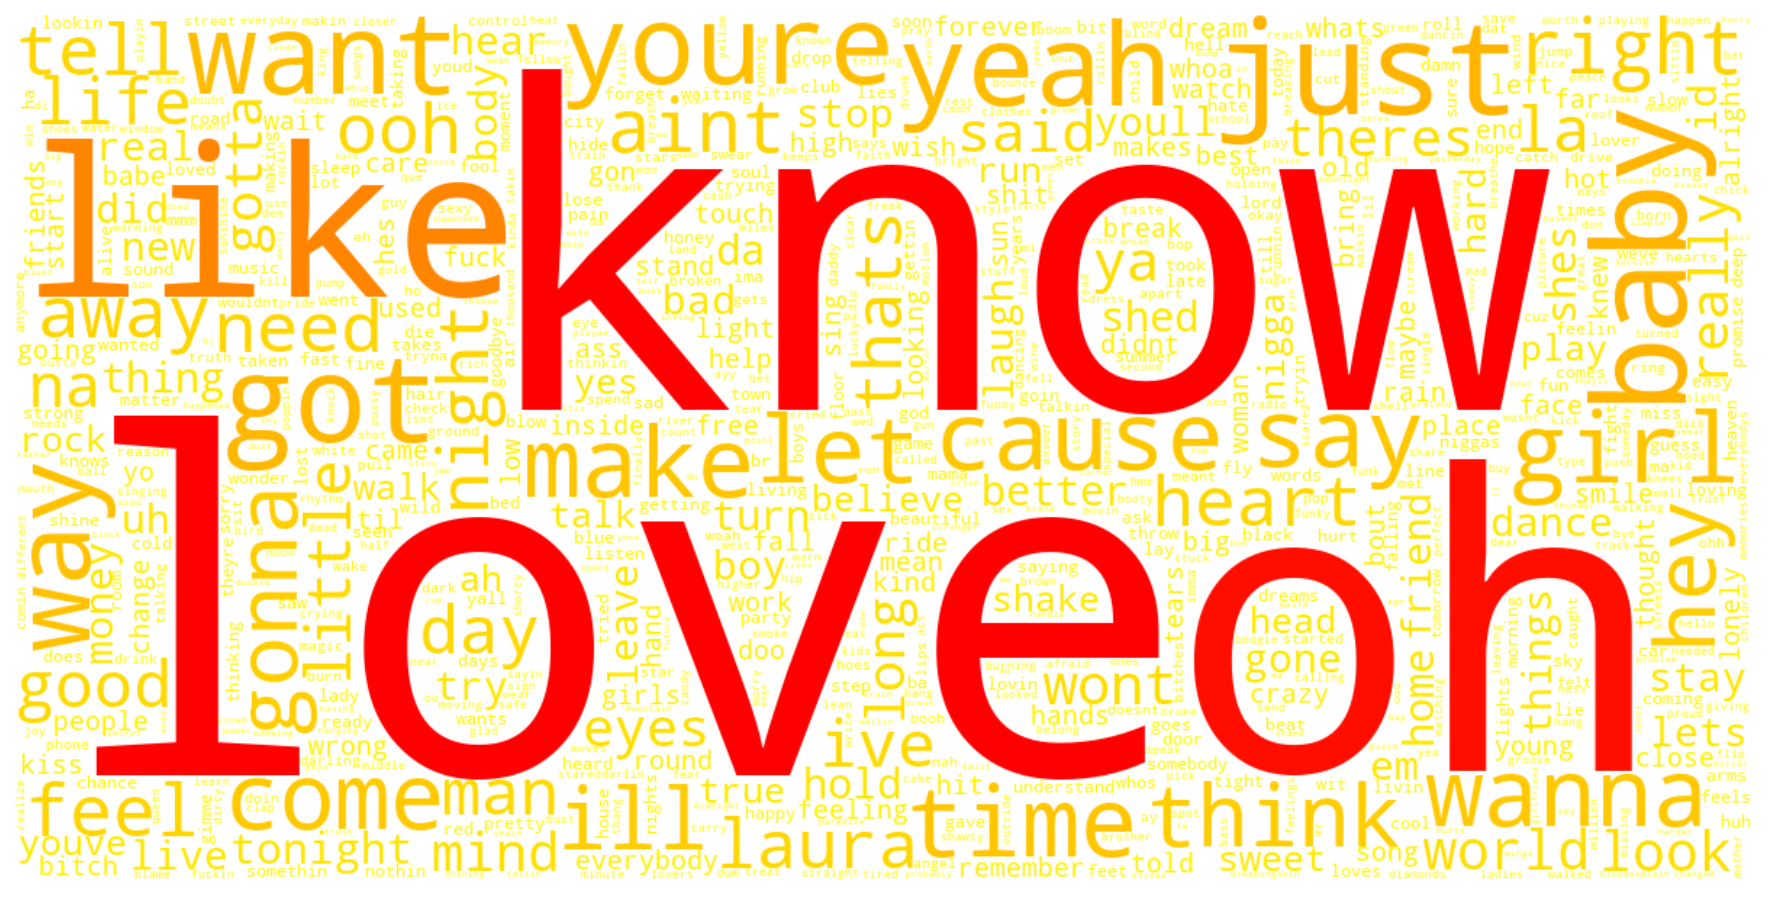

In [10]:
# calculate word frequencies
stop_words = list(ENGLISH_STOP_WORDS) + ['im', 'dont']
count = CountVectorizer(stop_words=stop_words)
count.fit(np.array(lyrics))
freqs = np.array(count.transform(np.array(lyrics)).todense()).sum(axis=0)

# make word cloud
word_freq_dict = dict(zip(count.get_feature_names(), freqs))
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2,
                      width=1200, color_func=colormap_size_func('autumn_r', 300),
                      max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');

## Most popular bigrams

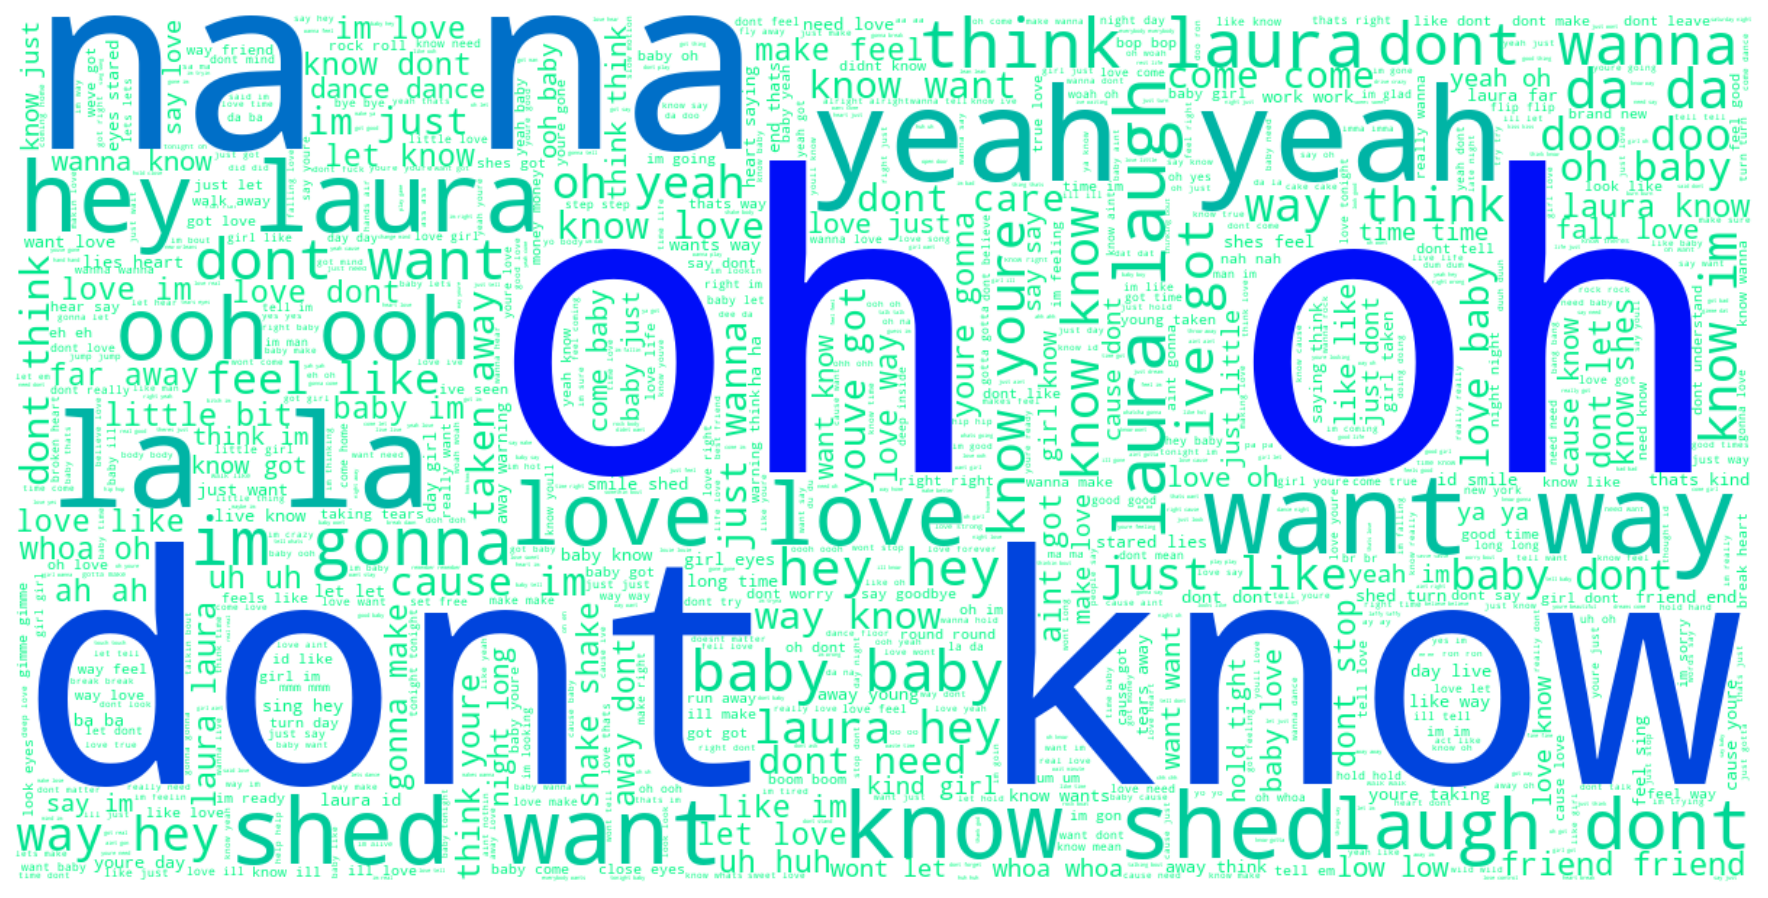

In [11]:
# calculate bigram frequencies
count_bigrams = CountVectorizer(stop_words='english', ngram_range=(2,2))
count_bigrams.fit(lyrics)
freq_bigrams = np.array(
    count_bigrams.transform(np.array(lyrics)).todense()).sum(axis=0)

# make word cloud
word_freq_dict = dict(zip(count_bigrams.get_feature_names(), freq_bigrams))
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2,
                      width=1200, color_func=colormap_size_func('winter_r', 300),
                      max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');